In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
from bs4 import BeautifulSoup 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce

# Import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


Name                                        Description  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...   
1  kml_2  <center><table><tr><th colspan='2' align='cent...   
2  kml_3  <center><table><tr><th colspan='2' align='cent...   
3  kml_4  <center><table><tr><th colspan='2' align='cent...   
4  kml_5  <center><table><tr><th colspan='2' align='cent...   

                                            geometry     PLN_AREA_N  \
0  POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...          BEDOK   
1  POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...       BOON LAY   
2  POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...    BUKIT BATOK   
3  POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...    BUKIT MERAH   
4  POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...  BUKIT PANJANG   

  PLN_AREA_C CA_IND        REGION_N REGION_C           INC_CRC      FMEL_UPD_D  
0         BD      N     EAST REGION       ER  5F00E6FF084F3364  20191223152014  
1         BL      N     WEST REGION       WR  C96AED188C00B2FC  20191223152014  
2         BK      N     WEST REGION       WR  3BEC4C829160F28A  20191223152014  
3         BM      N  CENTRAL REGION       CR  4850795BB0B6A4F7  20191223152014  
4         BP      N     WEST REGION       WR  656F87D23D6DAB02  20191223152014

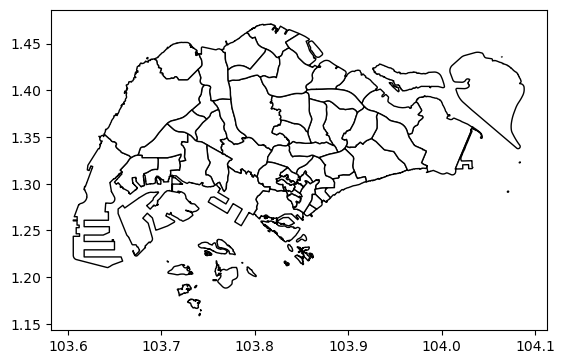

In [2]:
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

# Import daily historical data from 2016 to 2019

In [3]:
save_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\Weather\env_variables_2016_2018_2019"
historical_fps = [os.path.join(save_dir,fp) for fp in os.listdir(save_dir)]
historical_dfs = [pd.read_csv(fp) for fp in historical_fps]
historical_df = pd.concat(historical_dfs)
historical_df.head()
historical_df.groupby('time')['air-temperature_'].median().sort_values(ascending=False)

time
14:21:59    30.6
14:20:59    30.6
14:22:59    30.6
14:28:59    30.6
13:14:59    30.5
            ... 
23:55:00     NaN
23:56:00     NaN
23:57:00     NaN
23:58:00     NaN
23:59:00     NaN
Name: air-temperature_, Length: 2879, dtype: float64

# Import DUCT

In [4]:
save_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\DUCT\9th May 2018\CSV"
DUCT_fps = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if 'Planning areas.csv' in f]
# DUCT_dfs = {os.path.splitext(os.path.basename(fp))[0]: pd.read_csv(fp) for fp in DUCT_fps}
def read_DUCT_csv():
    DUCT_dfs = dict()
    for fp in DUCT_fps:
        param_time = os.path.splitext(os.path.basename(fp))[0]
        param = param_time.split('_')[0]
        df = pd.read_csv(fp)
        if param not in DUCT_dfs:
            DUCT_dfs[param] = {param_time: df}
        else:
            DUCT_dfs[param][param_time] = df

    return DUCT_dfs

DUCT_dfs = read_DUCT_csv()
DUCT_dfs

{'RH': {'RH_0100am_Planning areas':     OBJECTID *               PLN_AREA_N  ZONE_CODE  COUNT      AREA  \
  0            1                    BEDOK          1    242  0.001735   
  1            2                 BOON LAY          2     94  0.000674   
  2            3              BUKIT BATOK          3    126  0.000903   
  3            4              BUKIT MERAH          4    164  0.001176   
  4            5            BUKIT PANJANG          5    103  0.000738   
  5            6              BUKIT TIMAH          6    199  0.001427   
  6            7                   CHANGI          7    468  0.003355   
  7            8            CHOA CHU KANG          8     68  0.000487   
  8            9                 CLEMENTI          9    108  0.000774   
  9           10                  HOUGANG         10    156  0.001118   
  10          11              JURONG EAST         11    205  0.001470   
  11          12              JURONG WEST         12    164  0.001176   
  12          13 

### Get hottest and coldest WBGT

In [ ]:
DUCT_dfs['WBGT']['WBGT_0100am_Planning areas']
# concat a list of df and add a key
DUCT_WBGT = pd.concat(df.assign(df_name=k.split('_')[1]) for k, df in DUCT_dfs['WBGT'].items())
DUCT_WBGT['MEAN'] = pd.to_numeric(DUCT_WBGT['MEAN'],errors="coerce")
WBGT_coolest = DUCT_WBGT.groupby("PLN_AREA_N")['MEAN'].min().rename("WBGT_coolest").to_frame().reset_index()
WBGT_hottest = DUCT_WBGT.groupby("PLN_AREA_N")['MEAN'].max().rename("WBGT_hottest").to_frame().reset_index()
save_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\DUCT"
# WBGT_coolest.to_csv(os.path.join(save_dir,"WBGT_coolest.csv"),index=False)
# WBGT_hottest.to_csv(os.path.join(save_dir,"WBGT_hottest.csv"),index=False)

In [5]:
DUCT_dfs['RH']['RH_0100am_Planning areas']
def concat_DUCT(DUCT_dfs):
    df_list = []
    for df_type,df in DUCT_dfs.items():
        df['Variable'] = [df_type]*len(df)
        print(df_type,df['MEDIAN'].min())
        df_list.append(df)
    df_concat = pd.concat(df_list)
    numeric_cols = df_concat.columns[2:-1]
    # print(numeric_cols)
    for c in numeric_cols:
        df_concat[c] = pd.to_numeric(df_concat[c],errors="coerce")
    return df_concat.sort_values('MEAN',ascending=True)

print(list(DUCT_dfs))
DUCT_concat = concat_DUCT(DUCT_dfs['TA'])
DUCT_concat.head(10)

['RH', 'TA', 'WBGT', 'WD', 'WS']
TA_0100am_Planning areas 27.622498
TA_0200am_Planning areas 27.416519
TA_0300am_Planning areas 27.289734
TA_0400am_Planning areas 27.150681
TA_0500am_Planning areas 27.065552
TA_0600am_Planning areas 27.026657
TA_0700am_Planning areas 26.861374
TA_0800am_Planning areas 26.717484
TA_0900am_Planning areas 27.595154
TA_1000am_Planning areas 28.086212
TA_1100am_Planning areas 27.764038
TA_1200pm_Planning areas 29.135864
TA_1300pm_Planning areas 29.302429
TA_1400pm_Planning areas 29.628357
TA_1500pm_Planning areas 29.782013
TA_1600pm_Planning areas 29.782013
TA_1700pm_Planning areas 29.608459
TA_1800pm_Planning areas 29.552704
TA_1900pm_Planning areas 29.2966
TA_2000pm_Planning areas 28.373581
TA_2100pm_Planning areas 27.501938
TA_2200pm_Planning areas 27.25618
TA_2300pm_Planning areas 27.029907
TA_2400pm_Planning areas 26.937012


OBJECTID *               PLN_AREA_N  ZONE_CODE  COUNT      AREA  \
47          48                   MANDAI         48    132  0.000946   
47          48                   MANDAI         48    132  0.000946   
46          47                   TENGAH         47     86  0.000617   
53          54  WESTERN WATER CATCHMENT         54    793  0.005685   
47          48                   MANDAI         48    132  0.000946   
47          48                   MANDAI         48    132  0.000946   
53          54  WESTERN WATER CATCHMENT         54    793  0.005685   
54          55  CENTRAL WATER CATCHMENT         55    420  0.003011   
4            5            BUKIT PANJANG          5    103  0.000738   
51          52               PAYA LEBAR         52    136  0.000975   

          MIN        MAX     RANGE       MEAN       STD           SUM  \
47  26.172516  27.679077  1.506561  26.892457  0.448660   3549.804382   
47  26.243286  27.864532  1.621246  26.971746  0.450128   3560.270416   
46  26.366943  27.903687  1.536743  27.081298  0.367596   2328.991638   
53  25.729370  28.441742  2.712372  27.091611  0.580553  21483.647860   
47  26.412842  27.975891  1.563049  27.147580  0.430169   3583.480591   
47  26.562256  28.019897  1.457642  27.184315  0.424374   3588.329590   
53  25.781006  28.623199  2.842194  27.196929  0.593200  21567.164700   
54  26.137665  28.083740  1.946075  27.201573  0.583146  11424.660460   
4   26.303955  27.861237  1.557281  27.213425  0.413429   2802.982819   
51  26.097839  28.102905  2.005066  27.229183  0.547943   3703.168854   

       MEDIAN      PCT90                  Variable  
47  26.717484  27.580557  TA_0800am_Planning areas  
47  26.861374  27.668176  TA_0700am_Planning areas  
46  26.953934  27.668503  TA_0800am_Planning areas  
53  27.052948  27.738837  TA_0800am_Planning areas  
47  27.026657  27.813400  TA_0600am_Planning areas  
47  27.065552  27.837512  TA_0500am_Planning areas  
53  27.207336  27.827118  TA_0700am_Planning areas  
54  27.364212  27.917935  TA_0800am_Planning areas  
4   27.350983  27.628131  TA_0800am_Planning areas  
51  27.070160  27.908813  TA_0800am_Planning areas

In [6]:
DUCT_concat.groupby('PLN_AREA_N')['MAX'].max().sort_values(ascending=False)

PLN_AREA_N
WESTERN WATER CATCHMENT    33.360931
LIM CHU KANG               33.164948
CHOA CHU KANG              32.975983
TENGAH                     32.934662
YISHUN                     32.918060
JURONG WEST                32.917694
WESTERN ISLANDS            32.916840
SUNGEI KADUT               32.868744
WOODLANDS                  32.859222
MANDAI                     32.814240
JURONG EAST                32.793091
BUKIT TIMAH                32.763214
TUAS                       32.757904
ANG MO KIO                 32.587158
CLEMENTI                   32.555908
CENTRAL WATER CATCHMENT    32.555420
PIONEER                    32.503387
QUEENSTOWN                 32.488251
TOA PAYOH                  32.430115
BUKIT BATOK                32.413666
PASIR RIS                  32.402771
BUKIT PANJANG              32.369568
PAYA LEBAR                 32.354950
SELETAR                    32.339661
HOUGANG                    32.253296
NORTH-EASTERN ISLANDS      32.175201
NOVENA                     

60.673347 95.839401


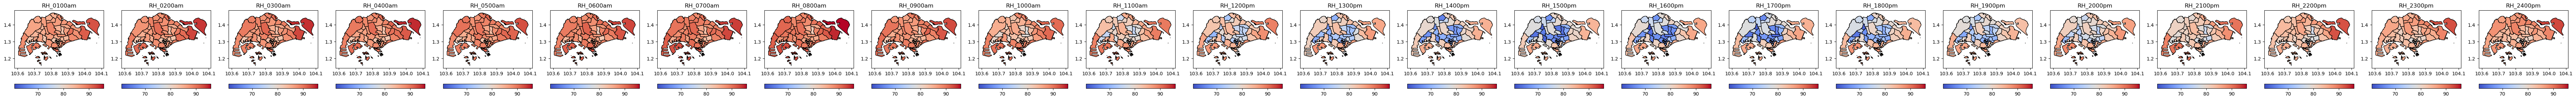

27.679077 33.360931


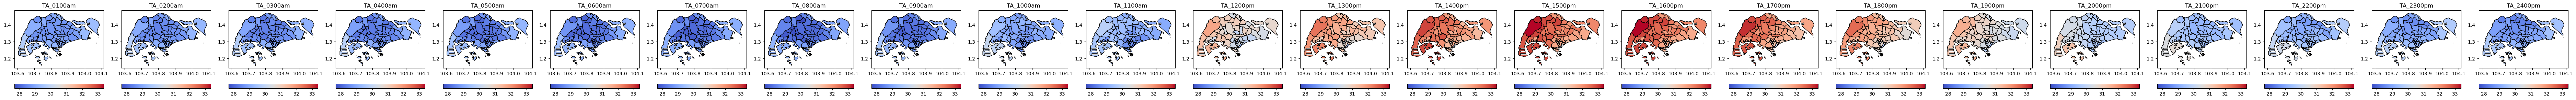

25.844864 36.043087


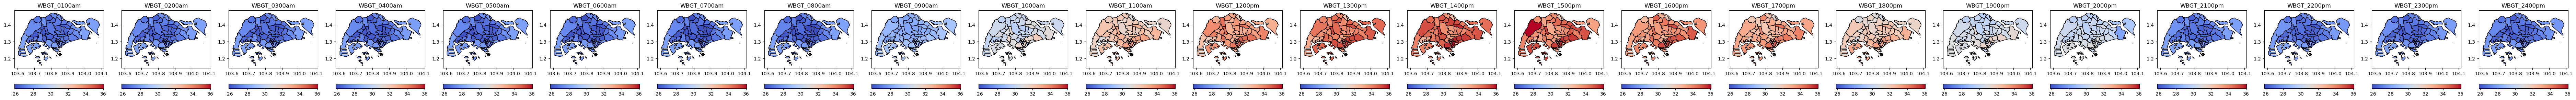

0.793374 7.239395


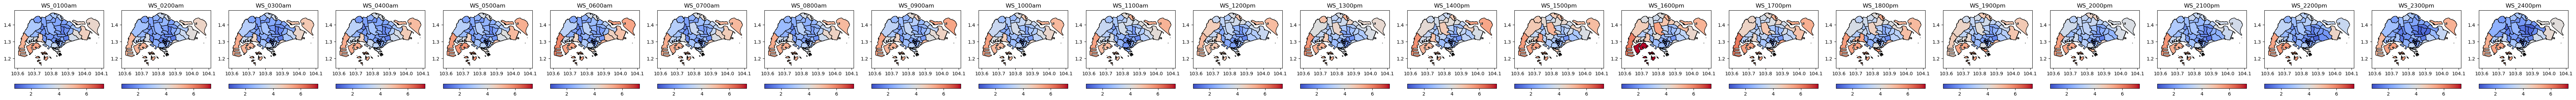

In [7]:
import matplotlib as mpl
def get_colorbar(vmin,vmax,label="Units",cmap="plasma",orientation="horizontal", plot=True):
    """ 
    Args:
        vmin (float): smallest value to be mapped to the start of color map
        vmax (float): largest value to be mapped to the end of color map
        label (str): label for colorbar e.g. units
        cmap (str): Name of the matplotlib colormap from which to choose the colors.
        orientation (str): orientation of colorbar e.g. horizontal, vertical
        plot (bool): if plot is True, plot colorbar
        ax (Ax or None): if ax is not None, plot colorbar next to existing Ax
    """

    cmap = plt.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin, vmax)
    cbar = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    # cax = ax (meaning "draw the colorbar on ax")
    # ax = ax (display the colorbar next to a pre-existing Axes ax)
    if plot:
        fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
        fig.colorbar(cbar,cax=ax, orientation=orientation, label=label)
    # else:
    #     fig.colorbar(cbar,ax=ax, orientation=orientation, label=label)
    return cbar

def plot_DUCT_data(planningArea,DUCT_df, param,title=None,ax=None,cmap='coolwarm',vmin=None,vmax=None):
    """  
    Args:
        planningArea (GeoDataFrame): GeoDataFrame containing planning area geometries.
        DUCT_df (DataFrame): DataFrame containing DUCT data with a column 'PLN_AREA_N'.
        param (str): The parameter to plot from the DUCT data.
        title (str, optional): Title for the plot. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If None, a new figure and axes will be created.
        cmap (str, optional): Colormap to use for the plot. Defaults to 'coolwarm'.
    """
    # merge planning area with DUCT data by column name PLN_AREA_N
    merged_df = planningArea.merge(DUCT_df,how='left', left_on='PLN_AREA_N', right_on='PLN_AREA_N')
    # plot the gpd merged_df based on 
    ax = merged_df.plot(column=param, ax=ax, legend=True, 
                        vmin = vmin, vmax = vmax,
                        cmap=cmap, edgecolor='black',legend_kwds={"orientation":"horizontal"})
    ax.set_title(title)
    return

for param in DUCT_dfs.keys():
    if param != 'WD':
        ncols = len(list(DUCT_dfs[param]))
        stat_param = 'MAX'
        fig, axes = plt.subplots(1,ncols,figsize=(ncols*4,4))
        vmin = min([df[stat_param].min() for df in DUCT_dfs[param].values()])
        vmax = max([df[stat_param].max() for df in DUCT_dfs[param].values()])
        print(vmin, vmax)
        for (time, df),ax in zip(DUCT_dfs[param].items(),axes.flatten()):
            title = time.replace("_Planning areas","")
            plot_DUCT_data(planningArea_shp,df, vmin=vmin, vmax=vmax,
                           param=stat_param,title=title,ax=ax,cmap='coolwarm')
        plt.show()